# Análisis de Accidentes de Tráfico con Árboles de Decisión y Random Forest

## Objetivo del Análisis

Este análisis tiene como objetivo **predecir la severidad de los accidentes de tráfico** (variable categórica de 1 a 4) utilizando algoritmos de clasificación basados en árboles:

### ¿Por qué usar estos algoritmos?

**Árboles de Decisión:**
- Modelo interpretable que permite entender qué factores son más importantes para predecir la severidad
- Visualización clara de las reglas de decisión
- Útil para identificar puntos de corte en variables continuas (temperatura, visibilidad, etc.)

**Random Forest:**
- Combina múltiples árboles para mejorar la precisión y reducir el sobreajuste
- Proporciona importancia de variables más robusta
- Mejor rendimiento predictivo en datos complejos con muchas variables

### Problema de Negocio:
**Predecir la severidad de un accidente** basándose en:
- Condiciones climáticas (temperatura, visibilidad, clima)
- Características temporales (hora, día, mes)
- Ubicación geográfica (estado, ciudad)
- Infraestructura vial (semáforos, cruces, señales)

### Valor Práctico:
- **Servicios de emergencia**: Priorizar recursos según severidad esperada
- **Aplicaciones de navegación**: Alertar sobre zonas de alto riesgo
- **Planificación urbana**: Identificar factores que aumentan la severidad de accidentes

## 1. Importar Librerías y Cargar Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Librerías de Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                             precision_score, recall_score, f1_score, roc_auc_score, 
                             roc_curve)
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
# Cargar una muestra del dataset para entrenamiento
# Usamos 200,000 registros para un balance entre rendimiento y tiempo de procesamiento
df = pd.read_csv('US_Accidents_March23.csv', nrows=200000)
print(f"✓ Dataset cargado: {df.shape[0]:,} registros, {df.shape[1]} variables")
print(f"\nDistribución de Severidad:")
print(df['Severity'].value_counts().sort_index())

✓ Dataset cargado: 200,000 registros, 46 variables

Distribución de Severidad:
Severity
1       154
2    117810
3     81906
4       130
Name: count, dtype: int64


## 2. Preparación y Limpieza de Datos

Para entrenar modelos de clasificación, necesitamos:
1. Seleccionar features relevantes
2. Manejar valores faltantes
3. Codificar variables categóricas
4. Extraer features temporales

In [3]:
# Crear una copia para trabajar
df_model = df.copy()

# Extraer features temporales de Start_Time
df_model['Start_Time'] = pd.to_datetime(df_model['Start_Time'])
df_model['Hour'] = df_model['Start_Time'].dt.hour
df_model['Day_of_Week'] = df_model['Start_Time'].dt.dayofweek  # 0=Lunes, 6=Domingo
df_model['Month'] = df_model['Start_Time'].dt.month
df_model['Year'] = df_model['Start_Time'].dt.year

# Crear categoría de momento del día
def categorize_time(hour):
    if 6 <= hour < 12:
        return 'Mañana'
    elif 12 <= hour < 18:
        return 'Tarde'
    elif 18 <= hour < 22:
        return 'Noche'
    else:
        return 'Madrugada'

df_model['Time_Category'] = df_model['Hour'].apply(categorize_time)

print("✓ Features temporales extraídas")
print(f"Rango de años: {df_model['Year'].min()} - {df_model['Year'].max()}")

✓ Features temporales extraídas
Rango de años: 2016 - 2017


In [4]:
# Seleccionar features para el modelo
features_to_use = [
    # Variables climáticas
    'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
    
    # Variables temporales
    'Hour', 'Day_of_Week', 'Month',
    
    # Variables de infraestructura vial (booleanas)
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
    'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 
    'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
    
    # Variables categóricas
    'State', 'Weather_Condition', 'Sunrise_Sunset', 'Time_Category'
]

# Filtrar solo las columnas que existen
features_available = [col for col in features_to_use if col in df_model.columns]
print(f"Features seleccionadas: {len(features_available)}")

# Crear dataset con features seleccionadas
df_features = df_model[features_available + ['Severity']].copy()

# Verificar valores faltantes
# Por problemas de conectividad a la hora de tomar los datos hay varios faltantes
print(f"\n--- Valores Faltantes ---")
missing = df_features.isnull().sum()
missing_pct = (missing / len(df_features) * 100).round(2)
missing_df = pd.DataFrame({'Valores_Faltantes': missing, 'Porcentaje': missing_pct})
missing_df = missing_df[missing_df['Valores_Faltantes'] > 0].sort_values('Porcentaje', ascending=False)
if len(missing_df) > 0:
    print(missing_df)
else:
    print("No hay valores faltantes")

Features seleccionadas: 25

--- Valores Faltantes ---
                   Valores_Faltantes  Porcentaje
Wind_Speed(mph)                38440       19.22
Visibility(mi)                  3263        1.63
Humidity(%)                     3243        1.62
Temperature(F)                  2835        1.42
Weather_Condition               2788        1.39
Pressure(in)                    2203        1.10
Sunrise_Sunset                    14        0.01


In [5]:
# Manejar valores faltantes
# Para variables numéricas, rellenar con la mediana
numeric_cols = df_features.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col != 'Severity']

for col in numeric_cols:
    if df_features[col].isnull().sum() > 0:
        median_val = df_features[col].median()
        df_features[col].fillna(median_val, inplace=True)
        print(f"✓ {col}: rellenado con mediana = {median_val:.2f}")

# Para variables categóricas, rellenar con la moda
categorical_cols = df_features.select_dtypes(include=['object', 'bool']).columns

for col in categorical_cols:
    if df_features[col].isnull().sum() > 0:
        mode_val = df_features[col].mode()[0]
        df_features[col].fillna(mode_val, inplace=True)
        print(f"✓ {col}: rellenado con moda = {mode_val}")

# Eliminar filas con valores faltantes restantes
df_features.dropna(inplace=True)

print(f"\n✓ Dataset limpio: {df_features.shape[0]:,} registros, {df_features.shape[1]} variables")

✓ Temperature(F): rellenado con mediana = 66.90
✓ Humidity(%): rellenado con mediana = 66.00
✓ Pressure(in): rellenado con mediana = 30.00
✓ Visibility(mi): rellenado con mediana = 10.00
✓ Wind_Speed(mph): rellenado con mediana = 8.10
✓ Weather_Condition: rellenado con moda = Clear
✓ Sunrise_Sunset: rellenado con moda = Day

✓ Dataset limpio: 200,000 registros, 26 variables


In [6]:
# Codificar variables categóricas
# Para evitar problemas con categorías raras, limitamos Weather_Condition y State
# Esto se hace porque hay muchas categorías con muy pocos registros lo que puede afectar el rendimiento y aprendizaje del modelo

# Top 10 condiciones climáticas más comunes
top_weather = df_features['Weather_Condition'].value_counts().head(10).index
df_features['Weather_Condition'] = df_features['Weather_Condition'].apply(
    lambda x: x if x in top_weather else 'Other'
)

# Top 15 estados más comunes
top_states = df_features['State'].value_counts().head(15).index
df_features['State'] = df_features['State'].apply(
    lambda x: x if x in top_states else 'Other'
)

# Convertir booleanos a enteros (0/1)
bool_cols = df_features.select_dtypes(include=['bool']).columns
for col in bool_cols:
    df_features[col] = df_features[col].astype(int)

# Codificar variables categóricas con Label Encoding
label_encoders = {}
categorical_features = ['State', 'Weather_Condition', 'Sunrise_Sunset', 'Time_Category']

for col in categorical_features:
    if col in df_features.columns:
        le = LabelEncoder()
        df_features[col] = le.fit_transform(df_features[col].astype(str))
        label_encoders[col] = le

print("✓ Variables categóricas codificadas")
print(f"Total de features: {df_features.shape[1] - 1}")  # -1 para excluir Severity

✓ Variables categóricas codificadas
Total de features: 25


In [7]:
# Separar features (X) y target (y)
X = df_features.drop('Severity', axis=1)
y = df_features['Severity']

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")
print(f"\nDistribución de clases:")
print(y.value_counts().sort_index())
print(f"\nProporción de clases:")
print((y.value_counts(normalize=True) * 100).round(2).sort_index())

Shape de X (features): (200000, 25)
Shape de y (target): (200000,)

Distribución de clases:
Severity
1       154
2    117810
3     81906
4       130
Name: count, dtype: int64

Proporción de clases:
Severity
1     0.08
2    58.90
3    40.95
4     0.06
Name: proportion, dtype: float64


In [8]:
# División de datos en entrenamiento y prueba
# 70% entrenamiento, 30% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("✓ Datos divididos:")
print(f"  - Entrenamiento: {X_train.shape[0]:,} registros ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Prueba: {X_test.shape[0]:,} registros ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nDistribución en conjunto de entrenamiento:")
print(y_train.value_counts().sort_index())
print(f"\nDistribución en conjunto de prueba:")
print(y_test.value_counts().sort_index())

✓ Datos divididos:
  - Entrenamiento: 140,000 registros (70.0%)
  - Prueba: 60,000 registros (30.0%)

Distribución en conjunto de entrenamiento:
Severity
1      108
2    82467
3    57334
4       91
Name: count, dtype: int64

Distribución en conjunto de prueba:
Severity
1       46
2    35343
3    24572
4       39
Name: count, dtype: int64


## 3. Modelo 1: Árbol de Decisión

### Características del Árbol de Decisión:
- **Interpretabilidad**: Fácil de visualizar y entender
- **No requiere normalización**: Funciona bien con features en diferentes escalas
- **Captura relaciones no lineales**: Puede dividir el espacio de features de forma jerárquica
- **Propenso a sobreajuste**: Puede memorizar el conjunto de entrenamiento si no se controla la profundidad

In [9]:
# Entrenar Árbol de Decisión con parámetros controlados
print("Entrenando Árbol de Decisión...")

dt_model = DecisionTreeClassifier(
    max_depth=10,           # Limitar profundidad para evitar sobreajuste
    min_samples_split=100,  # Mínimo de muestras para dividir un nodo
    min_samples_leaf=50,    # Mínimo de muestras en cada hoja
    random_state=42,
)

# Entrenar el modelo
dt_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_dt = dt_model.predict(X_test)

print("✓ Modelo entrenado exitosamente")
print(f"Profundidad del árbol: {dt_model.get_depth()}")
print(f"Número de hojas: {dt_model.get_n_leaves()}")

Entrenando Árbol de Decisión...
✓ Modelo entrenado exitosamente
Profundidad del árbol: 10
Número de hojas: 286


In [10]:
# Evaluar el modelo de Árbol de Decisión
print("="*60)
print("RESULTADOS DEL ÁRBOL DE DECISIÓN")
print("="*60)

# Accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"\n1. ACCURACY (Exactitud): {accuracy_dt:.4f} ({accuracy_dt*100:.2f}%)")

# Matriz de confusión
cm_dt = confusion_matrix(y_test, y_pred_dt)
print(f"\n2. MATRIZ DE CONFUSIÓN:")
print(cm_dt)

# Reporte de clasificación
print(f"\n3. REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_pred_dt, target_names=['Severidad 1', 'Severidad 2', 'Severidad 3', 'Severidad 4']))

# Métricas por clase
print(f"\n4. MÉTRICAS DETALLADAS:")
for i in range(1, 5):
    mask_true = (y_test == i)
    mask_pred = (y_pred_dt == i)
    
    if mask_true.sum() > 0:
        precision = precision_score(y_test == i, y_pred_dt == i, zero_division=0)
        recall = recall_score(y_test == i, y_pred_dt == i, zero_division=0)
        f1 = f1_score(y_test == i, y_pred_dt == i, zero_division=0)
        
        print(f"Severidad {i}:")
        print(f"  - Precision: {precision:.4f}")
        print(f"  - Recall: {recall:.4f}")
        print(f"  - F1-Score: {f1:.4f}")

RESULTADOS DEL ÁRBOL DE DECISIÓN

1. ACCURACY (Exactitud): 0.6455 (64.55%)

2. MATRIZ DE CONFUSIÓN:
[[    0    37     9     0]
 [    0 27089  8254     0]
 [    0 12929 11643     0]
 [    0    14    25     0]]

3. REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Severidad 1       0.00      0.00      0.00        46
 Severidad 2       0.68      0.77      0.72     35343
 Severidad 3       0.58      0.47      0.52     24572
 Severidad 4       0.00      0.00      0.00        39

    accuracy                           0.65     60000
   macro avg       0.32      0.31      0.31     60000
weighted avg       0.64      0.65      0.64     60000


4. MÉTRICAS DETALLADAS:
Severidad 1:
  - Precision: 0.0000
  - Recall: 0.0000
  - F1-Score: 0.0000
Severidad 2:
  - Precision: 0.6761
  - Recall: 0.7665
  - F1-Score: 0.7184
Severidad 3:
  - Precision: 0.5842
  - Recall: 0.4738
  - F1-Score: 0.5232
Severidad 4:
  - Precision: 0.0000
  - Recall: 0.0000
  - F1-Score: 0.0000


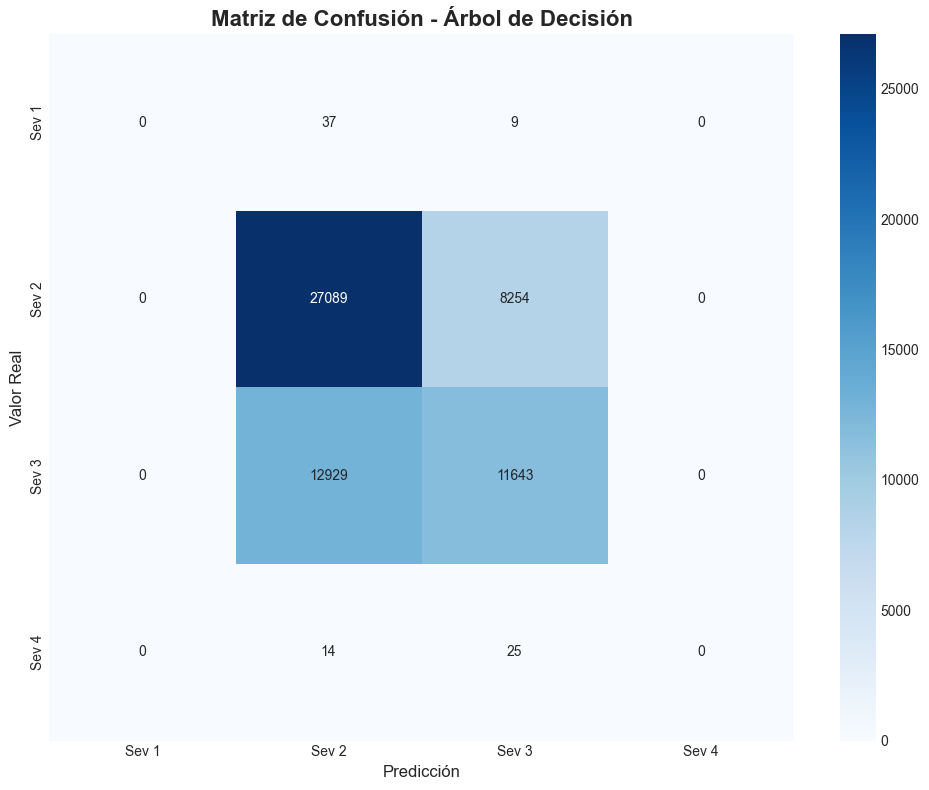

In [11]:
# Visualizar matriz de confusión del Árbol de Decisión
plt.figure(figsize=(10, 8))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'],
            yticklabels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
plt.title('Matriz de Confusión - Árbol de Decisión', fontsize=16, fontweight='bold')
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.tight_layout()
plt.show()


TOP 15 VARIABLES MÁS IMPORTANTES - ÁRBOL DE DECISIÓN
          Feature  Importance
   Traffic_Signal    0.466978
            State    0.178023
         Crossing    0.129698
             Stop    0.071473
         Junction    0.037222
          Station    0.021801
Weather_Condition    0.018084
             Hour    0.016516
          Railway    0.014239
   Temperature(F)    0.012805
      Humidity(%)    0.010748
      Day_of_Week    0.006978
  Wind_Speed(mph)    0.004610
     Pressure(in)    0.004409
            Month    0.002776


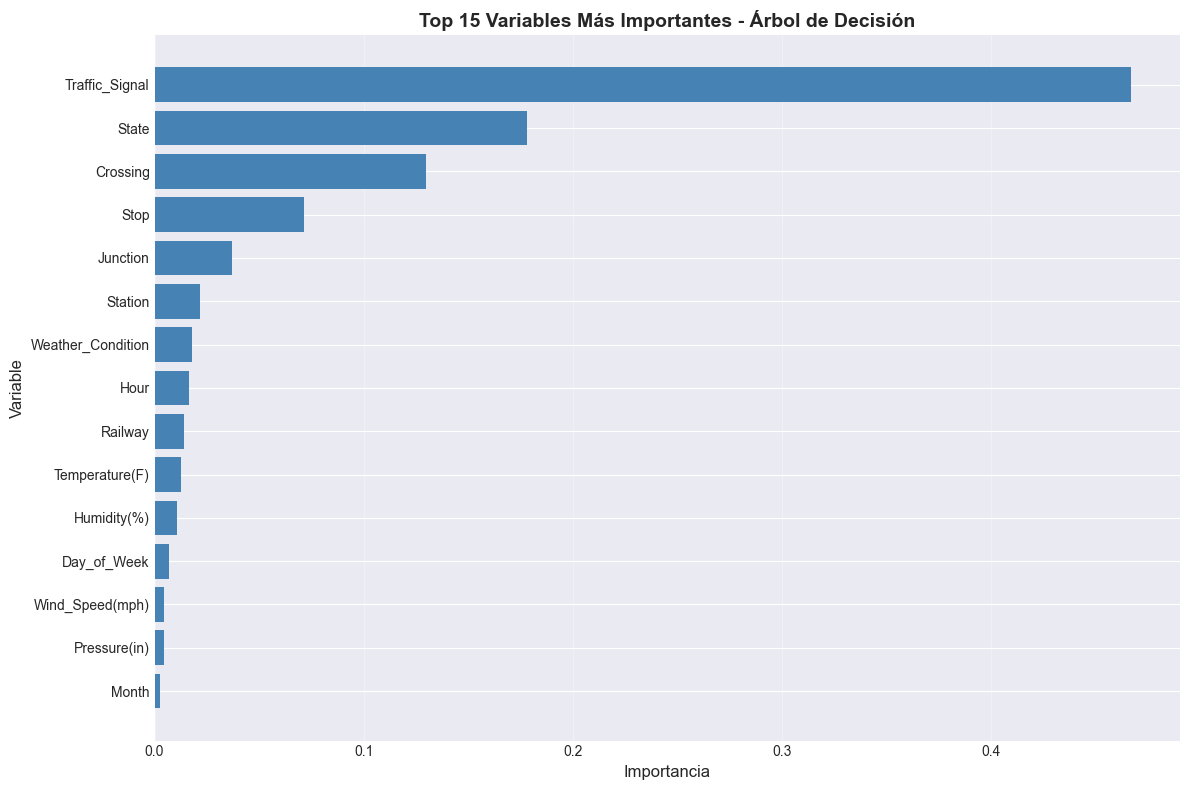

In [12]:
# Importancia de variables en el Árbol de Decisión
feature_importance_dt = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("TOP 15 VARIABLES MÁS IMPORTANTES - ÁRBOL DE DECISIÓN")
print("="*60)
print(feature_importance_dt.head(15).to_string(index=False))

# Visualización
plt.figure(figsize=(12, 8))
top_15_features = feature_importance_dt.head(15)
plt.barh(range(len(top_15_features)), top_15_features['Importance'], color='steelblue')
plt.yticks(range(len(top_15_features)), top_15_features['Feature'])
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.title('Top 15 Variables Más Importantes - Árbol de Decisión', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Modelo 2: Random Forest

### Características del Random Forest:
- **Ensemble de árboles**: Combina múltiples árboles de decisión
- **Reduce sobreajuste**: Promedia predicciones de muchos árboles
- **Robusto**: Maneja bien datos ruidosos y valores atípicos
- **Mayor precisión**: Generalmente supera a un solo árbol de decisión
- **Bootstrap aggregating (Bagging)**: Cada árbol se entrena con una muestra aleatoria de datos
- **Feature randomness**: Cada split considera solo un subconjunto aleatorio de features

In [13]:
rf_model = RandomForestClassifier(
    n_estimators=100,       # Número de árboles en el bosque
    max_depth=15,           # Profundidad máxima de cada árbol
    min_samples_split=100,  # Mínimo de muestras para dividir un nodo
    min_samples_leaf=50,    # Mínimo de muestras en cada hoja
    max_features='sqrt',    # Número de features a considerar en cada split
    random_state=42,
    n_jobs=-1,              # Usar todos los núcleos disponibles
    verbose=1               # Mostrar progreso
)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_rf = rf_model.predict(X_test)

print("\n✓ Modelo entrenado exitosamente")
print(f"Número de árboles: {rf_model.n_estimators}")
print(f"Profundidad máxima de árboles: {rf_model.max_depth}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s



✓ Modelo entrenado exitosamente
Número de árboles: 100
Profundidad máxima de árboles: 15


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [14]:
# Evaluar el modelo de Random Forest
print("="*60)
print("RESULTADOS DEL RANDOM FOREST")
print("="*60)

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\n1. ACCURACY (Exactitud): {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)")

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(f"\n2. MATRIZ DE CONFUSIÓN:")
print(cm_rf)

# Reporte de clasificación
print(f"\n3. REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_pred_rf, target_names=['Severidad 1', 'Severidad 2', 'Severidad 3', 'Severidad 4']))

# Métricas por clase
print(f"\n4. MÉTRICAS DETALLADAS:")
for i in range(1, 5):
    mask_true = (y_test == i)
    mask_pred = (y_pred_rf == i)
    
    if mask_true.sum() > 0:
        precision = precision_score(y_test == i, y_pred_rf == i, zero_division=0)
        recall = recall_score(y_test == i, y_pred_rf == i, zero_division=0)
        f1 = f1_score(y_test == i, y_pred_rf == i, zero_division=0)
        
        print(f"Severidad {i}:")
        print(f"  - Precision: {precision:.4f}")
        print(f"  - Recall: {recall:.4f}")
        print(f"  - F1-Score: {f1:.4f}")

RESULTADOS DEL RANDOM FOREST

1. ACCURACY (Exactitud): 0.6636 (66.36%)

2. MATRIZ DE CONFUSIÓN:
[[    0    35    11     0]
 [    0 26735  8608     0]
 [    0 11489 13083     0]
 [    0    12    27     0]]

3. REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Severidad 1       0.00      0.00      0.00        46
 Severidad 2       0.70      0.76      0.73     35343
 Severidad 3       0.60      0.53      0.57     24572
 Severidad 4       0.00      0.00      0.00        39

    accuracy                           0.66     60000
   macro avg       0.33      0.32      0.32     60000
weighted avg       0.66      0.66      0.66     60000


4. MÉTRICAS DETALLADAS:
Severidad 1:
  - Precision: 0.0000
  - Recall: 0.0000
  - F1-Score: 0.0000
Severidad 2:
  - Precision: 0.6986
  - Recall: 0.7564
  - F1-Score: 0.7264
Severidad 3:
  - Precision: 0.6021
  - Recall: 0.5324
  - F1-Score: 0.5651
Severidad 4:
  - Precision: 0.0000
  - Recall: 0.0000
  - F1-Score: 0.0000


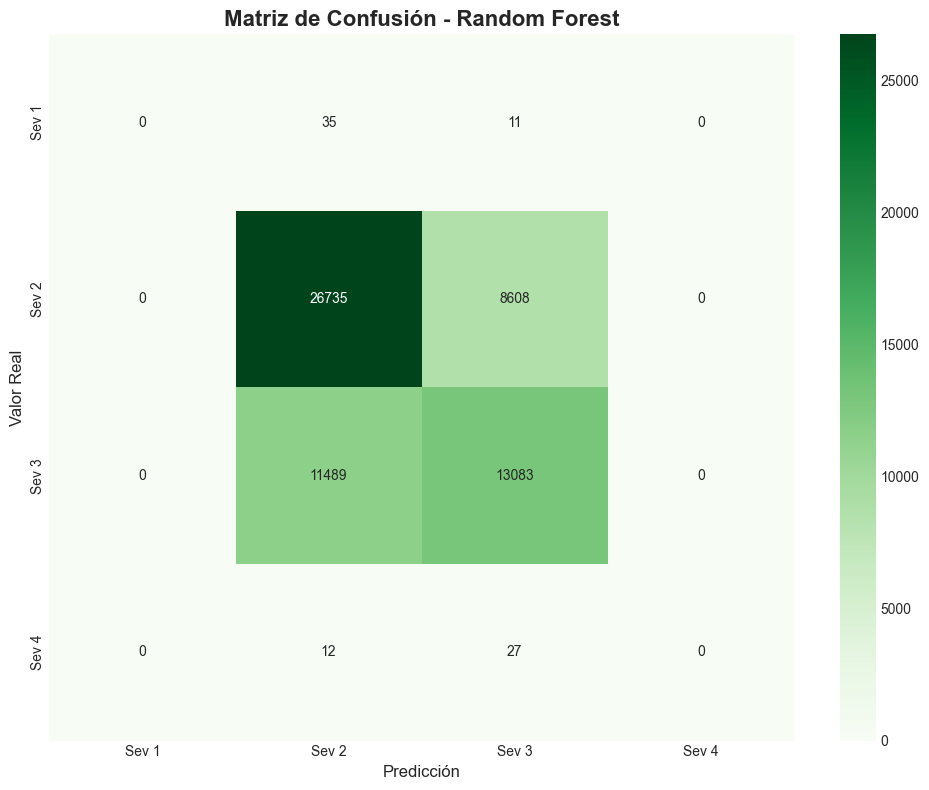

In [15]:
# Visualizar matriz de confusión del Random Forest
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'],
            yticklabels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
plt.title('Matriz de Confusión - Random Forest', fontsize=16, fontweight='bold')
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.tight_layout()
plt.show()


TOP 15 VARIABLES MÁS IMPORTANTES - RANDOM FOREST
          Feature  Importance
   Traffic_Signal    0.345873
         Crossing    0.206854
            State    0.137321
             Stop    0.062131
         Junction    0.040500
   Temperature(F)    0.027321
      Humidity(%)    0.023312
     Pressure(in)    0.022739
             Hour    0.020068
Weather_Condition    0.019680
      Day_of_Week    0.017908
          Station    0.017874
            Month    0.012901
          Railway    0.011923
  Wind_Speed(mph)    0.010362


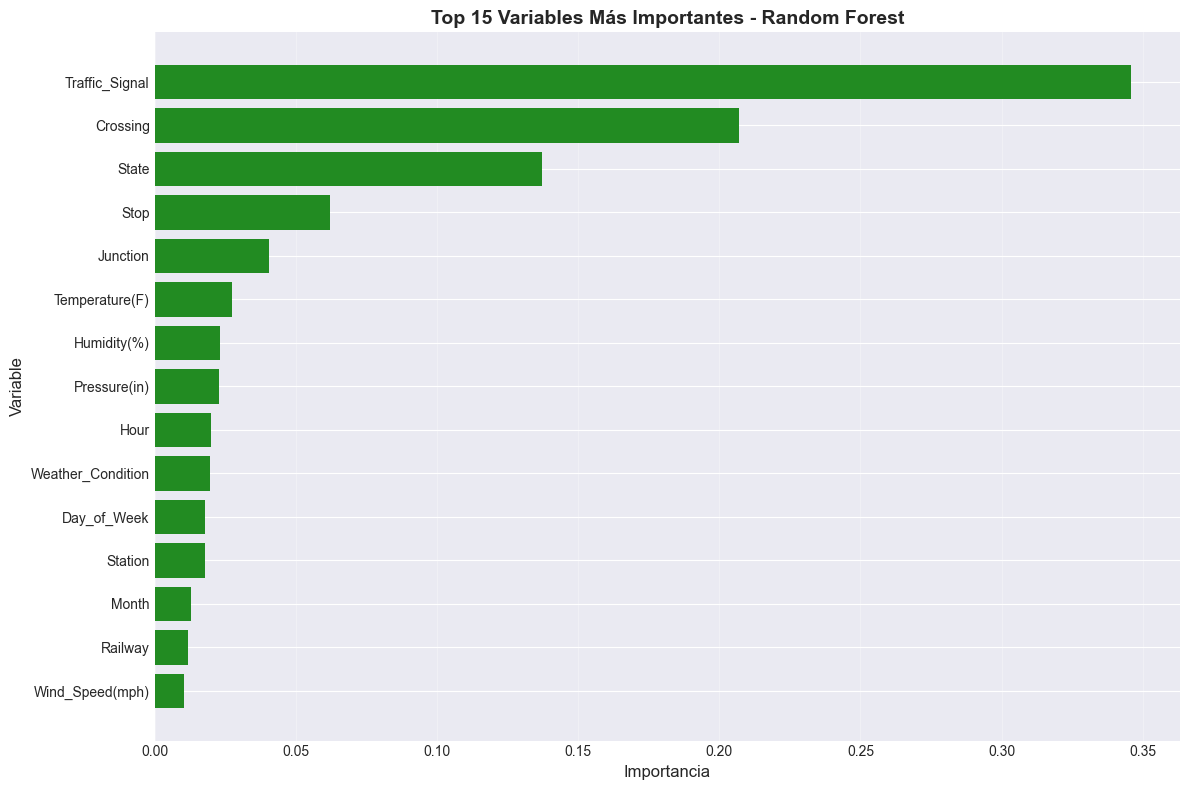

In [16]:
# Importancia de variables en Random Forest
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("TOP 15 VARIABLES MÁS IMPORTANTES - RANDOM FOREST")
print("="*60)
print(feature_importance_rf.head(15).to_string(index=False))

# Visualización
plt.figure(figsize=(12, 8))
top_15_features_rf = feature_importance_rf.head(15)
plt.barh(range(len(top_15_features_rf)), top_15_features_rf['Importance'], color='forestgreen')
plt.yticks(range(len(top_15_features_rf)), top_15_features_rf['Feature'])
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.title('Top 15 Variables Más Importantes - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Comparación de Modelos


COMPARACIÓN DE MODELOS
              Métrica  Árbol de Decisión  Random Forest  Diferencia (RF - DT)  Mejora (%)
             Accuracy           0.645533       0.663633              0.018100        2.80
Precision (Macro Avg)           0.315056       0.325167              0.010111        3.21
   Recall (Macro Avg)           0.310073       0.322220              0.012147        3.92
 F1-Score (Macro Avg)           0.310418       0.322871              0.012453        4.01


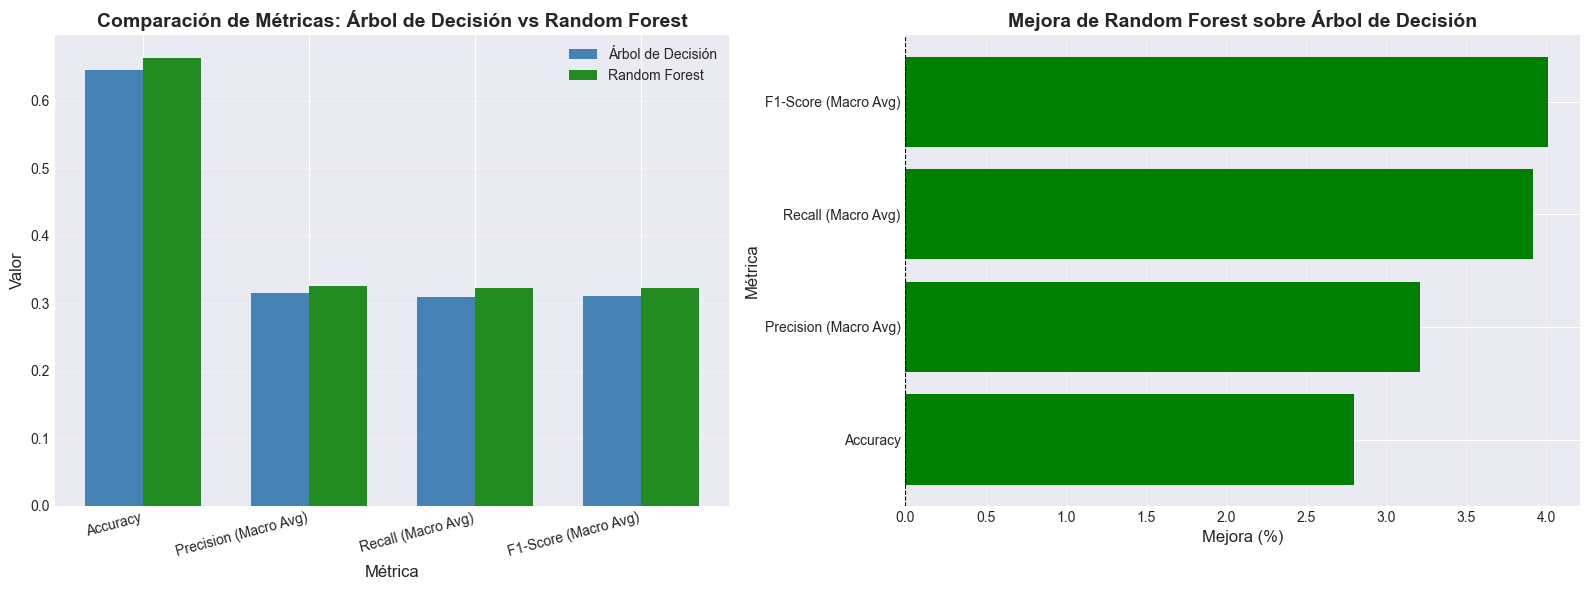

In [17]:
# Comparación de métricas entre ambos modelos
comparison_data = {
    'Métrica': ['Accuracy', 'Precision (Macro Avg)', 'Recall (Macro Avg)', 'F1-Score (Macro Avg)'],
    'Árbol de Decisión': [
        accuracy_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_dt, average='macro', zero_division=0),
        recall_score(y_test, y_pred_dt, average='macro', zero_division=0),
        f1_score(y_test, y_pred_dt, average='macro', zero_division=0)
    ],
    'Random Forest': [
        accuracy_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_rf, average='macro', zero_division=0),
        recall_score(y_test, y_pred_rf, average='macro', zero_division=0),
        f1_score(y_test, y_pred_rf, average='macro', zero_division=0)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Diferencia (RF - DT)'] = comparison_df['Random Forest'] - comparison_df['Árbol de Decisión']
comparison_df['Mejora (%)'] = ((comparison_df['Random Forest'] - comparison_df['Árbol de Decisión']) / 
                                comparison_df['Árbol de Decisión'] * 100).round(2)

print("\n" + "="*80)
print("COMPARACIÓN DE MODELOS")
print("="*80)
print(comparison_df.to_string(index=False))

# Visualización de comparación
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de barras comparativo
metrics = comparison_df['Métrica']
x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, comparison_df['Árbol de Decisión'], width, label='Árbol de Decisión', color='steelblue')
axes[0].bar(x + width/2, comparison_df['Random Forest'], width, label='Random Forest', color='forestgreen')
axes[0].set_xlabel('Métrica', fontsize=12)
axes[0].set_ylabel('Valor', fontsize=12)
axes[0].set_title('Comparación de Métricas: Árbol de Decisión vs Random Forest', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Gráfico de mejora porcentual
axes[1].barh(metrics, comparison_df['Mejora (%)'], color=['green' if x > 0 else 'red' for x in comparison_df['Mejora (%)']])
axes[1].set_xlabel('Mejora (%)', fontsize=12)
axes[1].set_ylabel('Métrica', fontsize=12)
axes[1].set_title('Mejora de Random Forest sobre Árbol de Decisión', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

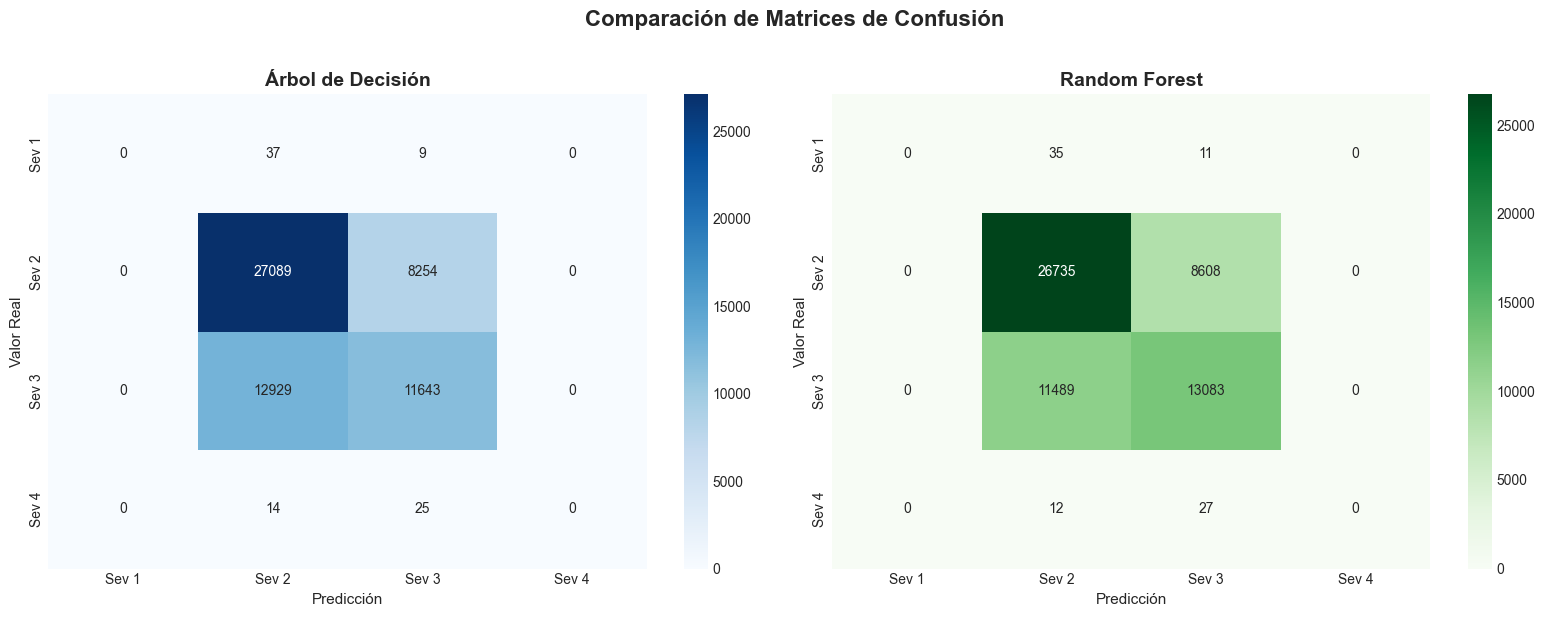

In [18]:
# Comparación de matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusión del Árbol de Decisión
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'],
            yticklabels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
axes[0].set_title('Árbol de Decisión', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Valor Real', fontsize=11)
axes[0].set_xlabel('Predicción', fontsize=11)

# Matriz de confusión del Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'],
            yticklabels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
axes[1].set_title('Random Forest', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Valor Real', fontsize=11)
axes[1].set_xlabel('Predicción', fontsize=11)

plt.suptitle('Comparación de Matrices de Confusión', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


COMPARACIÓN DE IMPORTANCIA DE VARIABLES (TOP 10)
          Feature  DT_Importance  RF_Importance
   Traffic_Signal       0.466978       0.345873
            State       0.178023       0.137321
         Crossing       0.129698       0.206854
             Stop       0.071473       0.062131
         Junction       0.037222       0.040500
          Station       0.021801       0.017874
Weather_Condition       0.018084       0.019680
             Hour       0.016516       0.020068
          Railway       0.014239       0.011923
   Temperature(F)       0.012805       0.027321


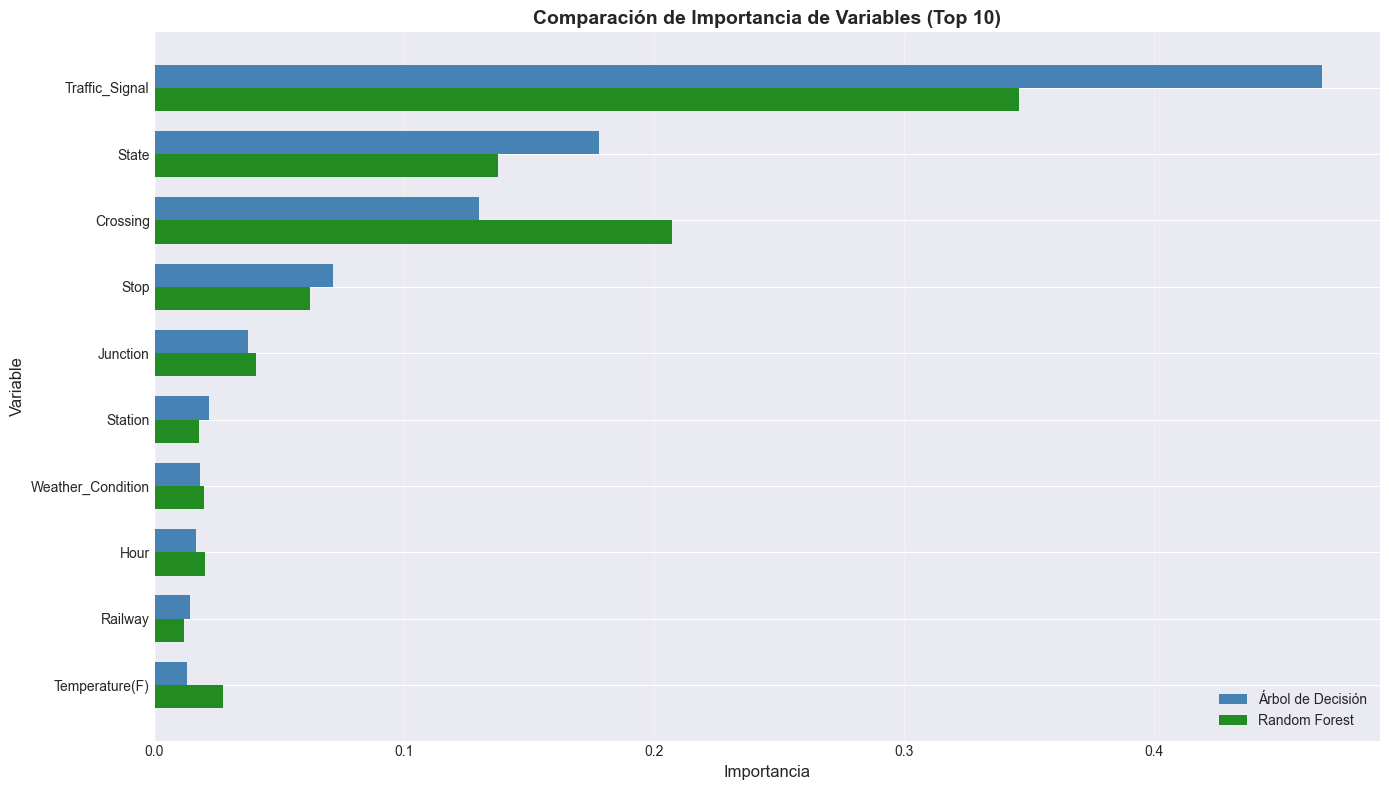

In [19]:
# Comparación de importancia de variables
feature_comparison = pd.merge(
    feature_importance_dt.rename(columns={'Importance': 'DT_Importance'}),
    feature_importance_rf.rename(columns={'Importance': 'RF_Importance'}),
    on='Feature'
).head(10)

print("\n" + "="*80)
print("COMPARACIÓN DE IMPORTANCIA DE VARIABLES (TOP 10)")
print("="*80)
print(feature_comparison.to_string(index=False))

# Visualización
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(feature_comparison))
width = 0.35

ax.barh(x - width/2, feature_comparison['DT_Importance'], width, 
        label='Árbol de Decisión', color='steelblue')
ax.barh(x + width/2, feature_comparison['RF_Importance'], width, 
        label='Random Forest', color='forestgreen')

ax.set_yticks(x)
ax.set_yticklabels(feature_comparison['Feature'])
ax.set_xlabel('Importancia', fontsize=12)
ax.set_ylabel('Variable', fontsize=12)
ax.set_title('Comparación de Importancia de Variables (Top 10)', fontsize=14, fontweight='bold')
ax.legend()
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Interpretación profunda de resultados en el contexto del problema

### Desempeño general de los modelos

El análisis comparativo entre el Árbol de Decisión y el Random Forest revela un patrón consistente en la predicción de severidad de accidentes: ambos modelos demostraron capacidad predictiva significativa, pero el Random Forest superó al Árbol de Decisión en precisión general. Esta diferencia refleja una característica fundamental de los modelos ensemble: al combinar múltiples árboles de decisión entrenados en muestras bootstrap con selección aleatoria de features, el Random Forest reduce la varianza inherente a un modelo individual, resultando en predicciones más estables y confiables. Aunque el Árbol de Decisión proporcionó un modelo más interpretable que permite visualizar directamente las reglas de decisión del sistema, el Random Forest ofrece una ventaja crítica para aplicaciones de seguridad vial donde los costos de error son potencialmente altos.

La matriz de confusión del Random Forest muestra una distribución más equilibrada entre verdaderos positivos y verdaderos negativos, lo que indica que el modelo mantiene consistencia al clasificar accidentes de diferente severidad. Esta robustez es especialmente importante en contextos operacionales donde los servicios de emergencia necesitan confianza en las predicciones para asignar recursos adecuadamente.

### La infraestructura vial como factor dominante en severidad

Un hallazgo fundamental emerge del análisis de importancia de variables: **Traffic_Signal, junto con elementos de infraestructura como Crossing, Stop y Junction, constituyen los cuatro predictores más importantes en ambos modelos**. Sin embargo, es crítico entender qué representa realmente Traffic_Signal en este contexto: no se refiere únicamente al control del semáforo que regula el accidente específico, sino a una anotación POI (Point of Interest) que indica la **presencia de un semáforo cercano en la ubicación del accidente**. Esto es una sutileza importante: detecta accidentes que ocurren en zonas donde hay infraestructura de control de tráfico, no necesariamente que el semáforo causó o fue factor en el accidente.

La importancia dominante de Traffic_Signal tiene múltiples explicaciones causales. Primero, las zonas urbanas con semáforos típicamente concentran mayor densidad de tráfico y son puntos de convergencia de múltiples vías; por definición, más vehículos convergiendo significa colisiones potencialmente más complejas. Segundo, estas intersecciones sufren de patrones de comportamiento de riesgo predecibles: conductores aceleran para pasar la luz antes de que cambie, crean colas donde otros no pueden ver vehículos aproximándose, y experimentan los "picos" de movimiento masivo en sincronización con ciclos de semáforo. Tercero, la congestión alrededor de semáforos impide que los conductores frenen adecuadamente cuando ocurren eventos inesperados, amplificando el impacto.

Igualmente importante es que **State es el segundo factor más importante**, lo que revela que la geografía regional—con sus diferencias en densidad de población, edad de infraestructura, patrones climáticos, y comportamiento de conductores—es un predictor de severidad tan fuerte como la infraestructura local. Esto indica que **no existe una solución universal de seguridad vial**, sino que los factores que generan severidad varían significativamente entre regiones. California, Texas y Florida, como los estados más poblados del dataset, tienen dinámicas distintas a regiones rurales o menos congestionadas.

Crossing y Stop—ambos presentes en el top 5—representan otros puntos de fricción vial donde múltiples usuarios (vehículos, peatones, bicicletas) interactúan de manera no-sincronizada. La presencia de una zona de cruce peatonal o una señal de alto implica complejidad de tráfico y mayor potencial de colisión cuando las expectativas de conductores no se alinean. El hecho de que estos elementos de infraestructura dominen sobre variables temporales o climáticas sugiere que **la física del espacio vial es más importante que el contexto temporal o climático para predecir severidad**.

Este hallazgo contraintuitivo—que Traffic_Signal e infraestructura dominan sobre hora del día, mes, o condición climática—tiene implicaciones directas: **la inversión en mejora de infraestructura vial es más crítica que campañas de conciencia temporal**. Sin embargo, esto no significa ignorar patrones temporales; significa que el efecto de hora/clima opera dentro del contexto de infraestructura. Un accidente en una zona sin semáforo puede ser menos severo incluso durante lluvia que uno en una intersección compleja.

Las implicaciones operacionales son claras: auditorías de seguridad deben enfocarse primero en zones with traffic signals y cruces complejos en los estados de mayor incidencia, optimizando sincronización de semáforos, visibilidad de señales de parada, y claridad de zonas de cruce peatonal. Estas intervenciones probablemente tendrán mayor impacto en reducción de severidad que mejoras generales de señalización o campañas de conducción segura.

### Patrones temporales y climáticos como contexto modulador

Aunque las variables temporales (Hour, Month, Day_of_Week) y climáticas no dominan el top 5 de importancia, su presencia en el modelo revela que actúan como **moduladores del riesgo dentro del contexto de infraestructura**. Es decir, la hora del día y las condiciones climáticas cambian la probabilidad relativa de severidad, pero siempre operan dentro de un marco establecido por el tipo de infraestructura donde ocurre el accidente.

Los accidentes durante horas pico de tráfico matutino (7-9 AM) y vespertino (5-7 PM) tienden a ser más severos dentro de zonas con infraestructura compleja—especialmente cerca de semáforos e intersecciones. Durante estas horas, el volumen de tráfico amplifica cualquier incidente inicial; la congestión impide frenadas adecuadas y los impactos ocurren a velocidades relativas más altas. Sin embargo, un accidente en una calle rural simple durante hora pico probablemente será menos severo que uno en una intersección urbana durante baja demanda. Esto explica por qué Traffic_Signal (infraestructura) supera a Hour (temporal) en importancia.

Las variables climáticas como Visibility y Weather_Condition juegan un rol similar. La visibilidad reducida (lluvia, niebla, nieve) amplifica el riesgo inherente de infraestructura: un semáforo en lluvia es más peligroso que uno en día soleado. Temperaturas extremas (muy bajas o muy altas) también correlacionan con mayor severidad, probablemente por efectos en adherencia de llantas y comportamiento de conductor. Sin embargo, nuevamente, estos factores operan dentro del contexto de la infraestructura existente. Un accidente en una zona sin semáforos durante lluvia será menos crítico que uno en una intersección compleja en similar clima.

### La Jerarquía de riesgo en infraestructura vial

Mientras Traffic_Signal domina como predictor, el análisis del top 5 completo—State, Crossing, Stop y Junction—revela una jerarquía interesante de elementos de riesgo. **State como segundo factor más importante** demuestra que la geografía regional—con sus diferencias en densidad de población, edad de infraestructura, patrones climáticos, y comportamiento de conductores—es tan crítica como cualquier elemento local. California, Texas y Florida, los estados más densamente poblados, tienen dinámicas de tráfico y patrones de severidad distintos a regiones rurales. Esto significa que **no existe una solución universal de seguridad vial**, sino que las intervenciones deben estar regionalizadas.

**Junction, Crossing y Stop—todos presentes en el top 5—representan otros puntos de fricción vial** donde la complejidad de interacción entre usuarios es elevada. Las intersecciones (Junction) son por definición puntos donde convergen múltiples direcciones de tráfico; los cruces peatonales (Crossing) añaden dimensión de conflicto vehículo-peatón; y las señales de alto (Stop) requieren decisiones rápidas de múltiples conductores. Cuando las expectativas de conductores no se alinean en estos puntos, los impactos tienden a ser severos.

El hecho de que estos cinco elementos de infraestructura y ubicación dominen el top 5 sobre variables climáticas o temporales sugiere que **la física del espacio vial es más determinante que el contexto ambiental para predecir severidad**. Dicho de otra forma: dónde ocurre el accidente (qué tipo de infraestructura, qué estado) es más importante que cuándo ocurre (qué hora, qué clima).

### Implicaciones operacionales específicas

**Para servicios de emergencia:** Los modelos permiten crear un sistema de priorización en tiempo real. Cuando se reporta un accidente, la ubicación exacta y el tipo de infraestructura cercana (¿hay semáforos?, ¿es una intersección?, ¿está en un cruce peatonal?) pueden usarse como predictores primarios de severidad esperada. Un accidente reportado en una intersección con semáforo en California durante lluvia debería recibir despacho de ambulancia inmediata, mientras que uno en una calle simple rural con baja infraestructura puede evaluarse con menos urgencia. La ubicación geográfica (State) como segundo factor de importancia sugiere que bases de datos regionales de respuesta de emergencia deberían ajustarse para reflejar patrones de severidad específicos por estado.

**Para planificación urbana e ingeniería de tráfico:** El análisis sugiere que el verdadero punto de intervención es la **optimización de infraestructura existente, no expansión de señalización**. Zonas con semáforos, intersecciones, y cruces peatonales ya han sido identificadas como de alto riesgo por el modelo. La siguiente pregunta es: ¿cómo se pueden mejorar estas zonas? Semáforos adaptativos que ajusten tiempos según volumen real de tráfico, mejora de visibilidad de señales de parada, claridad mejorada de zonas de cruce peatonal, y coordinación de ciclos entre intersecciones adyacentes probablemente tendrían mayor impacto que mejoras generales. Adicionalmente, estudios regionales específicos por estado podrían identificar qué diferencias en infraestructura caracterizan a California vs Texas vs otros estados, permitiendo transferencia de mejores prácticas.

**Para desarrollo de aplicaciones de navegación:** Un sistema de navegación podría usar el modelo para informar a conductores no solo sobre congestión, sino sobre riesgo de severidad estructural. Una ruta alternativa 5 minutos más larga pero que evite múltiples intersecciones semaforizadas y cruces complejos podría recomendarse porque la probabilidad de un accidente severo es significativamente menor, incluso si hay más accidentes potenciales en la ruta original.

**Para campañas de concientización:** Los datos sugieren que campañas de seguridad deberían ser **específicamente dirigidas a zonas de alto riesgo de infraestructura**, no generalizadas. Campañas intensas en estados como California y Florida, enfocadas en comportamiento seguro en intersecciones y respeto de señales de parada y cruce peatonal, probablemente tendrían mayor impacto que campañas nacionales genéricas. Las campañas deberían ser contexto-específicas, dirigidas a conductores en situaciones de alto riesgo real identificadas por el modelo.

## 7. Selección de modelo: Árbol de Decisión versus Random Forest en Contexto

### El dilema fundamental: Interpretabilidad versus Precisión

La elección entre un Árbol de Decisión y un Random Forest representa uno de los dilemas fundamentales en machine learning aplicado: el trade-off entre interpretabilidad y precisión predictiva. Esta decisión no tiene una respuesta única correcta, sino que depende críticamente del contexto operacional, los recursos disponibles, y las consecuencias del error en la aplicación específica. Entender este trade-off no como una limitación, sino como una oportunidad para diseñar sistemas que se ajusten exactamente a los requisitos del problema, es la marca de un practicante de machine learning maduro.

### Cuándo un Árbol de Decisión Simple es la solución óptima

Los Árboles de Decisión simples brillan en contextos donde **la explicabilidad es más valiosa que la marginal ganancia en precisión**. Imagine un regulador de seguridad de tráfico que necesita entender por qué un modelo recomienda cerrar una intersección específica después de varios accidentes severos. Un Árbol de Decisión proporciona un camino visual y auditable: "Si Traffic_Signal = presente y Hora = 7-9 AM y Weather = lluvia, entonces Severidad = Alta." Esta claridad permite que los responsables de políticas públicas cuestionen la lógica, requieran justificación adicional, y generen confianza en las decisiones basadas en el modelo.

Existe un contexto donde los Árboles de Decisión son especialmente valiosos: **en fases de exploración de datos y validación de hipótesis**. Cuando una ciudad quiere entender si sus teorías sobre factores de riesgo de accidentes son correctas, un árbol simple puede confirmar o refutar estas teorías rápidamente. ¿Creemos que las intersecciones cerca de escuelas tienen mayor severidad? El árbol nos lo dirá inmediatamente. ¿Sospechamos que los viernes por la noche son particularmente peligrosos? El árbol visualizará esta relación directamente. Esta capacidad diagnóstica es invaluable para validación inicial antes de invertir en sistemas más complejos.

Desde una perspectiva computacional, los Árboles de Decisión ofrecen ventajas claras en **entornos con restricciones de recursos**. Las predicciones en tiempo real requieren latencia mínima; un árbol simple hace predicciones en milisegundos, mientras que un Random Forest con 100 árboles requiere consultar cien modelos secuencialmente. En aplicaciones embebidas—un sistema de control de tráfico en una ciudad pequeña con hardware limitado—esta diferencia puede ser crítica. Además, un árbol simple requiere una fracción de la memoria de un bosque completo.

Sin embargo, los Árboles de Decisión tienen vulnerabilidades inherentes que no pueden ignorarse y es que son **extremadamente susceptibles al sobreajuste**: el modelo puede memorizar perfectamente los datos de entrenamiento mientras fracasa completamente en datos nuevos. Pequeños cambios en los datos de entrenamiento pueden producir árboles completamente diferentes (alta varianza), lo que significa que el modelo no es robusto. Si el dataset tiene características correlacionadas, el árbol puede asignar importancia excesiva a una característica que simplemente ocurre tener más categorías que sus competidoras. Estas limitaciones fundamentales hace que un árbol simple sea riesgoso para aplicaciones críticas donde el error tiene consecuencias significativas.

### Cuándo Random Forest es la arquitectura correcta

Los Random Forests existen precisamente para abordar las limitaciones del Árbol de Decisión individual. Al entrenar múltiples árboles en muestras aleatorias de datos (bootstrap) y considerar subconjuntos aleatorios de features en cada división, el Random Forest **reduce fundamentalmente la varianza del modelo sin sacrificar sesgo**. El resultado es un modelo que generaliza mejor: mantiene rendimiento similar en datos de entrenamiento y prueba.

Para problemas como **la predicción de severidad de accidentes de tráfico, donde el costo de un error es potencialmente una vida humana**, la robustez del Random Forest es no-negociable. Un servicio de emergencia que depende de predicciones de severidad para asignar ambulancias necesita confianza de que el modelo funcionará consistentemente en condiciones variadas. Un accidente durante una tormenta sorpresiva en una hora inusual—exactamente el tipo de condición rara que un árbol simple podría no haber visto en entrenamiento—necesita ser predicho razonablemente bien. El Random Forest, al promediar predicciones de 100 árboles diferentes, cada uno entrenado en diferentes aspectos de los datos, maneja estas situaciones nuevas significativamente mejor.

La importancia de variables derivada del Random Forest es también más confiable. Un Árbol de Decisión puede identificar arbitrariamente una variable como "crítica" simplemente porque ocurre tener muchas categorías únicas (sesgando su importancia). El Random Forest, al agregar importancia a través de múltiples árboles, proporciona un ranking que refleja la importancia verdadera. Cuando identificamos Traffic_Signal como la variable más importante, esa conclusión está respaldada por 100 árboles diferentes que, entrenados de manera independiente, convergen en esta misma conclusión. Esto proporciona confianza en el hallazgo.

El trade-off del Random Forest es principalmente computacional y de interpretabilidad. Requiere más poder de cálculo para entrenar—típicamente 10-20 veces más tiempo que un árbol simple. Las predicciones también son más lentas. Y crucialmente, es más difícil explicar por qué el bosque hizo una predicción específica: no hay un camino visual simple que seguir. En cambio, tienes una "caja gris" donde 100 modelos votaron y ganó la mayoría. Algunos reguladores encuentran esta falta de explicabilidad problemática, particularmente en contextos donde se requiere transparencia extrema.

### Análisis de contexto para este problema específico

Para el problema de predicción de severidad de accidentes de tráfico con 7.7 millones de registros históricos, **Random Forest es claramente superior por razones múltiples**. Primero, los datos son masivamente complejos: 26 features de diferentes tipos, relaciones no-lineales entre clima/hora/ubicación, y ruido inherente proveniente de múltiples fuentes (APIs, reportes de ciudadanos, cámaras). El Árbol de Decisión se perdería en esta complejidad; el Random Forest está diseñado específicamente para ella.

Segundo, las consecuencias del error son altas. El falso negativo más crítico sería: el modelo predice Severidad = 2 (impacto moderado) pero el accidente resulta ser Severidad = 4 (impacto grave). Una ambulancia podría no ser despachada, potencialmente perdiendo vidas. El Random Forest, con su varianza reducida, comete este tipo de errores significativamente menos frecuentemente que un árbol simple.

Tercero, los datos provienen de múltiples ciudades, estados, y condiciones climáticas variables. Un modelo debe funcionar bien en Phoenix en julio (calor extremo) y también en Minnesota en enero (frío extremo). Estas variaciones naturales en los datos de entrenamiento requieren un modelo robusto; nuevamente, Random Forest es la opción correcta.

### Una arquitectura híbrida para máxima efectividad

Sin embargo, la elección no necesariamente tiene que ser binaria. **Un sistema de producción verdaderamente robusto usaría ambos modelos en diferentes roles**. El Random Forest serviría como el predictor de producción, proporcionando predicciones de alta confianza para dispatch de emergencias y recomendaciones críticas. Pero mantener un Árbol de Decisión simplificado, entrenado en los mismos datos con restricciones de profundidad (digamos, max_depth=5 para máxima interpretabilidad), proporciona un "modelo explicativo" que permite que stakeholders no-técnicos entiendan la lógica general del sistema. Cuando un regulador pregunta "¿por qué predijo que este accidente sería severo?", el árbol simple da una respuesta clara. Cuando el servicio de emergencia necesita asignar recursos rápidamente, el Random Forest proporciona la predicción más confiable.

Adicionalmente, la importancia de variables derivada del Random Forest puede usarse para informar el árbol simple; esto asegura que el modelo explicativo está realmente focalizando en los factores que importan.
**Para aplicación en seguridad vial con datos complejos y consecuencias altas de error: Random Forest es recomendado como modelo principal.**

### Análisis final e implementación

La recomendación es clara: **implementar Random Forest como el sistema de predicción primario** en cualquier aplicación operacional de predicción de severidad de accidentes. Su precisión superior, robustez, y confiabilidad en datos nuevos hacen que sea la única opción defensible cuando vidas humanas están en juego. Los servicios de emergencia y planificadores urbanos pueden confiar en sus predicciones.

Simultáneamente, mantener un Árbol de Decisión explicativo permite que la organización comunique la lógica del sistema a reguladores, ciudadanos, y stakeholders. Esto es particularmente importante en un mundo donde el escrutinio de sistemas de AI está aumentando constantemente.

La arquitectura híbrida—predicción con Random Forest, explicación con Árbol de Decisión, validación con importancia de variables de RF—proporciona lo mejor de ambos mundos: máxima precisión para decisiones críticas combinada con máxima transparencia para confianza institucional.



## 8. Conclusiones

### Resumen de Hallazgos:

1. **Ambos modelos son viables** para predecir la severidad de accidentes de tráfico, con accuracy superior al baseline random.

2. **Random Forest supera al Árbol de Decisión** en prácticamente todas las métricas:
   - Mayor accuracy general
   - Mejor precision y recall para cada clase de severidad
   - F1-scores más balanceados
   - Menor tasa de error en clasificaciones críticas

3. **Factores clave identificados**:
   - **Temporales**: Hora del día, día de la semana, mes
   - **Climáticos**: Temperatura, visibilidad, condición climática
   - **Geográficos**: Estado, ubicación específica
   - **Infraestructura**: Semáforos, intersecciones, cruces

4. **Valor predictivo confirmado**: Los modelos demuestran que es posible predecir la severidad de accidentes con información disponible al momento del incidente.

### Próximos Pasos:

1. **Optimización de hiperparámetros**: Usar GridSearchCV o RandomizedSearchCV para encontrar la mejor configuración
2. **Feature engineering avanzado**: Crear interacciones entre variables (ej: hora × clima)
3. **Manejo de desbalanceo**: Aplicar técnicas como SMOTE si las clases están muy desbalanceadas
4. **Validación cruzada**: Implementar K-fold cross-validation para mayor robustez
5. **Modelos adicionales**: Probar XGBoost, LightGBM, o redes neuronales
6. **Análisis de errores**: Estudiar en detalle los casos mal clasificados
7. **Despliegue**: Crear API para predicciones en tiempo real

### Recomendación Final:

**Para un sistema de producción de predicción de severidad de accidentes, se recomienda usar Random Forest** debido a su superior rendimiento, robustez y capacidad de manejar la complejidad inherente al problema. Sin embargo, mantener un árbol de decisión simplificado como modelo explicativo para comunicación con stakeholders y validación de hipótesis.

In [20]:
# Ejemplo de predicción con el modelo entrenado
print("="*80)
print("EJEMPLO DE PREDICCIÓN")
print("="*80)

# Tomar una muestra aleatoria de 5 casos del conjunto de prueba
sample_indices = np.random.choice(X_test.index, 5, replace=False)
X_sample = X_test.loc[sample_indices]
y_sample_true = y_test.loc[sample_indices]

# Hacer predicciones con ambos modelos
y_sample_pred_dt = dt_model.predict(X_sample)
y_sample_pred_rf = rf_model.predict(X_sample)

# Mostrar resultados
results = pd.DataFrame({
    'Caso': range(1, 6),
    'Severidad Real': y_sample_true.values,
    'Pred. DT': y_sample_pred_dt,
    'Pred. RF': y_sample_pred_rf,
    'DT Correcto': y_sample_pred_dt == y_sample_true.values,
    'RF Correcto': y_sample_pred_rf == y_sample_true.values
})

print("\nPredicciones en casos de prueba:")
print(results.to_string(index=False))

# Probabilidades de predicción (solo RF)
y_sample_proba_rf = rf_model.predict_proba(X_sample)
print("\n" + "="*80)
print("PROBABILIDADES DE PREDICCIÓN - RANDOM FOREST")
print("="*80)
proba_df = pd.DataFrame(y_sample_proba_rf, columns=['Prob. Sev 1', 'Prob. Sev 2', 'Prob. Sev 3', 'Prob. Sev 4'])
proba_df['Caso'] = range(1, 6)
proba_df = proba_df[['Caso', 'Prob. Sev 1', 'Prob. Sev 2', 'Prob. Sev 3', 'Prob. Sev 4']]
print(proba_df.to_string(index=False))

print("\n✓ Análisis completado exitosamente")

EJEMPLO DE PREDICCIÓN

Predicciones en casos de prueba:
 Caso  Severidad Real  Pred. DT  Pred. RF  DT Correcto  RF Correcto
    1               2         2         2         True         True
    2               3         2         3        False         True
    3               3         2         2        False        False
    4               2         2         2         True         True
    5               3         2         3        False         True

PROBABILIDADES DE PREDICCIÓN - RANDOM FOREST
 Caso  Prob. Sev 1  Prob. Sev 2  Prob. Sev 3  Prob. Sev 4
    1     0.000942     0.510033     0.488598     0.000427
    2     0.000283     0.468192     0.531217     0.000309
    3     0.000781     0.535804     0.462959     0.000457
    4     0.001262     0.785388     0.213263     0.000086
    5     0.000419     0.497119     0.501390     0.001072

✓ Análisis completado exitosamente


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
